# Controlled protein expression efficacy

**Computes the change in network relative entropy from viral PPIs after setting immune system proteins, one at a time, to high abundance {1,0}.**

In [1]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import copy as copy
from tqdm.notebook import tqdm
import math
import scipy.stats as st

from CoRe import reader
from CoRe.ncip import ncip
from CoRe.BA_C import BA

import importlib

import networkx as nx
import matplotlib.pyplot as plt
import json

from matplotlib import cm
from matplotlib import rcParams
import matplotlib.patches as patches

In [2]:
data_directory = "./Examples/Immune_System"
os.chdir(data_directory)

edge_data = pd.read_pickle('Immune_System_medium-PPI-edges.pkl')
node_data = pd.read_pickle('Immune_System_medium-PPI-nodes.pkl')

In [3]:
remake_graph = False

if remake_graph==False:
    netObj = ncip()
    netObj.load_graph('Immune_System-medium-PPI.gml')
else:
    netObj = ncip()
    netObj.load_data(edge_data,node_data)
    netObj.make_graph()
    netObj.save_network(pathway_nametag,network_type)

**All immune system communication network proteins that have PPI with SARS-CoV-2 proteins.**

In [4]:
f = open('SARS_CoV2-Immune_System_interactions.json')
SARS_nodes = json.load(f)
f.close()

all_sars_nodes = []

for s in SARS_nodes.keys():
    all_sars_nodes += SARS_nodes[s]
    
all_sars_nodes = list(set(all_sars_nodes))

print(all_sars_nodes)

['RHOA', 'SLC27A2', 'PVR', 'ELOB', 'EIF4E2', 'CYB5R3', 'NLRX1', 'RAB14', 'ECSIT', 'AP2A2', 'CSNK2B', 'HECTD1', 'ERP44', 'IL17RA', 'ITGB1', 'RALA', 'RAB10', 'NEU1', 'IMPDH2', 'TOMM70', 'GGH', 'PTGES2', 'TBK1', 'RIPK1', 'RAB7A', 'ANO6', 'HMOX1', 'SLC44A2', 'NPC2', 'RNF41', 'RAB18', 'GOLGA7', 'ELOC', 'STOM', 'RAB5C', 'GLA']


**Specifying the reference state and construction of the global transition matrix.**

In [5]:
initial_state_type = 'maxEnt'

errorname = '0.0'
rho = float(errorname)

input_bits = 1
code_length = int(2**input_bits)

max_entropy_state = (1.0/float(code_length))*np.ones(shape=(code_length,))

low_state = np.zeros(shape=(code_length,))
low_state[-1] = 1.0

high_state = np.zeros(shape=(code_length,))
high_state[0] = 1.0

if initial_state_type=='high':
    initial_state = high_state
elif initial_state_type=='low':
    initial_state = low_state
else:
    initial_state = max_entropy_state

print(high_state,low_state)

netObj.construct_C(rho,h=input_bits,neglect_modules=[])
node_list = list(netObj.G_d.nodes)

[1. 0.] [0. 1.]


**Disconnect all drugs from the network.**

In [6]:
netObj.disconnect_drug_nodes()

**Compute the reference stationary state of the network.**

In [7]:
initial_network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
network_sources = {}

for n in range(0,len(node_list)):
    initial_network_state[code_length*n:code_length*(n+1),0] = initial_state
    
network_sources = []

reference_final_state, steps = netObj.get_final_state(initial_network_state,[])
reference_final_entropy = netObj.state_entropy(reference_final_state,[])
print('Reference state relative entropy: ',reference_final_entropy)

Reference state relative entropy:  0.0


**Set the SARS-CoV-2 nodes in the network to low abundance.**

In [8]:
network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
network_sources = []

for n in range(0,len(node_list)):
    network_state[code_length*n:code_length*(n+1),0] = initial_state

for k in tqdm(SARS_nodes.keys()):
    for n in SARS_nodes[k]:
        try:
            i = node_list.index(n)

            network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = low_state

            if i not in network_sources:
                network_sources.append(i)
        except ValueError:
            pass

  0%|          | 0/17 [00:00<?, ?it/s]

**Relative entropy of the total network and number of steps to stationary state.**

In [9]:
final_state, steps = netObj.get_final_state(network_state,network_sources)
SARSCoV2_entropy = netObj.state_entropy(final_state,network_sources)

**Compute stationary state of the network due to SARS-CoV-2 PPIs and proteins.**

The proteins in the Reactome database were set to the state {1,0} to compute the stationary state, and the subsequent change in the network relative entropy.

In [10]:
node_class = nx.get_node_attributes(netObj.G_d,"class")
node_n = list(netObj.G_d.nodes())

c = 0

for i in range(0,len(node_n)):
    nn = node_n[i]
    if node_class[nn]=='EntityWithAccessionedSequence':
        relH = st.entropy(final_state[netObj.code_length*i:netObj.code_length*(i+1),0],max_entropy_state,base=2)
        
        if relH>0.01:
            c += 1

In [11]:
all_sources = []

for n in netObj.G_d.nodes(data=True):
    if n[1]['class']=='EntityWithAccessionedSequence' and n[0] not in all_sars_nodes:
        all_sources.append((n[0],netObj.G_d.in_degree(n[0])))

In [12]:
df_H_with_proteins = pd.DataFrame()
df_H_drop_and_gain = pd.DataFrame()

df_H_with_proteins = pd.DataFrame([],columns=['Protein', 'Relative Entropy'])

df_H_drop_and_gain = pd.DataFrame([],columns=['Protein', 'Drop', 'Gain'])

In [13]:
for this_protein in tqdm(all_sources):
    s = this_protein[0]
    additional_source_nodes = [s]
    
    netObj.construct_C(rho,h=input_bits)
    netObj.disconnect_nodes('ChemicalDrug',additional_source_nodes)
    netObj.disconnect_nodes('ProteinDrug',additional_source_nodes)
    
    network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
    network_sources = []
    
    for n in range(0,len(node_list)):
        network_state[code_length*n:code_length*(n+1),0] = initial_state

    for k in SARS_nodes.keys():
        for n in SARS_nodes[k]:
            try:
                i = node_list.index(n)

                network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = low_state

                network_sources.append(i)
            except ValueError:
                pass

        for n in additional_source_nodes:
            try:
                i = node_list.index(n)

                network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = high_state

                network_sources.append(i)
            except ValueError:
                pass
        
    this_state, steps = netObj.get_final_state(network_state,network_sources)
    H_with_proteins = netObj.state_entropy(this_state,network_sources)
    H_drop, H_gain = netObj.entropy_drop_and_rise(this_state,final_state,reference_final_state,network_sources)
                
    df_temp = pd.DataFrame([[this_protein[0],H_with_proteins]],columns=['Protein','Relative Entropy'])
    df_H_with_proteins = pd.concat([df_H_with_proteins,df_temp],sort=False,ignore_index=True)

    df_temp = pd.DataFrame([[this_protein[0],H_drop,H_gain]],columns=['Protein', 'Drop', 'Gain'])
    df_H_drop_and_gain = pd.concat([df_H_drop_and_gain,df_temp],sort=False,ignore_index=True)

  0%|          | 0/1122 [00:00<?, ?it/s]

In [14]:
try:
    os.chdir('./counter_entropic_shift')
except OSError:
    os.mkdir('./counter_entropic_shift')
    os.chdir('./counter_entropic_shift')

In [15]:
df_H_with_proteins = df_H_with_proteins.sort_values(by=['Relative Entropy'],ignore_index=True)

In [25]:
#df_temp = pd.DataFrame([['Ref',SARSCoV2_entropy]],columns=['Protein','Relative Entropy'])
#df_H_with_proteins = pd.concat([df_temp,df_H_with_proteins],sort=False,ignore_index=True)

#df_H_with_proteins.to_csv('high_all_protein_shifts-'+initial_state_type+'.csv',index=False)

df_H_drop_and_gain = df_H_drop_and_gain.sort_values(by=['Drop'],ascending=True,ignore_index=True)
df_H_drop_and_gain.to_csv('split_all_high_protein_shifts-'+initial_state_type+'.csv',index=False)

In [26]:
c_high = df_H_with_proteins['Relative Entropy'][1:] - SARSCoV2_entropy
r_min, r_max = np.min(c_high), np.max(c_high)
max_r = max(abs(r_min),abs(r_max))
v_min, v_max = -abs(r_min), abs(r_min)

**Immune system proteins ranked by $\Delta H_{\mathrm{ref}}(X)$.**

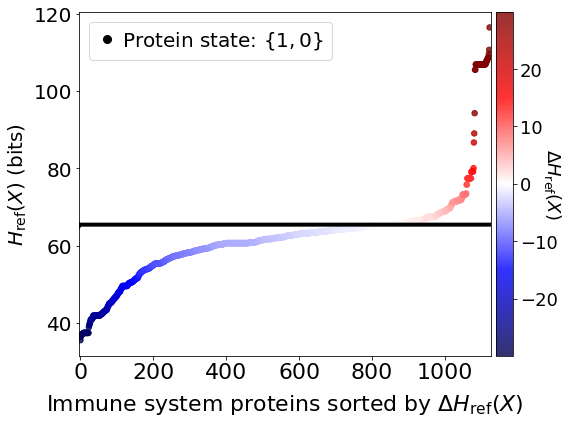

In [27]:
all_tick_names = df_H_with_proteins['Protein'].to_list()[1:]
data_size = len(all_tick_names)
x = np.linspace(1,data_size,data_size)

tick_names = [n.split(' [')[0] for n in all_tick_names]

fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(x,df_H_with_proteins['Relative Entropy'][1:],c=c_high,cmap=cm.seismic,vmin=v_min,vmax=v_max,marker='o',alpha=0.8,s=30)
plt.plot(x,SARSCoV2_entropy*np.ones(shape=x.shape),color='black',markersize=0,linewidth=4,alpha=1.0)
plt.plot(-10,df_H_with_proteins['Relative Entropy'][0],lw=0,ms=8,marker='o',label=r'Protein state: $\{1,0\}$',c='black')

plt.xlim(-3,data_size+5)

plt.ylabel(r'$H_{\mathrm{ref}}(X)$ (bits)',size=20)
plt.tick_params(axis='y',labelsize=20)
plt.tick_params(axis='x',labelsize=22)

plt.xlabel('Immune system proteins sorted by $\Delta H_{\mathrm{ref}}(X)$',size=22,labelpad=10)

plt.legend(frameon=True,fontsize=20,handlelength=1.0,handletextpad=0.25,loc='upper left')

cbar = plt.colorbar(fraction=0.05,pad=0.01)

cbar.set_label(r'$\Delta H_{\mathrm{ref}}(X)$',fontsize=18,rotation=-90,labelpad=5)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

**Immune system proteins ranked by the drop component of $\Delta H_{\mathrm{ref}}(X)$.**

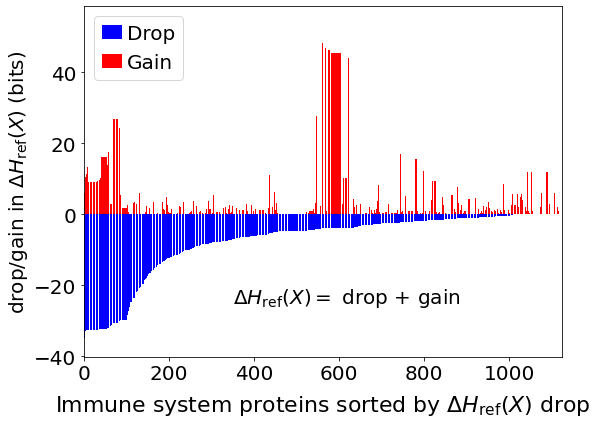

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

plt.bar(x,df_H_drop_and_gain['Drop'],color='Blue',label='Drop')
plt.bar(x,df_H_drop_and_gain['Gain'],color='Red',label='Gain')
plt.xlim(-0.5,len(df_H_drop_and_gain['Protein'])+0.5)

plt.ylabel(r'drop/gain in $\Delta H_{\mathrm{ref}}(X)$ (bits)',size=20)
plt.tick_params(axis='x',labelsize=20)
plt.tick_params(axis='y',labelsize=20)
plt.xlabel(r'Immune system proteins sorted by $\Delta H_{\mathrm{ref}}(X)$ drop',size=22,labelpad=10)
plt.text(350,-25,r'$\Delta H_{\mathrm{ref}}(X)=$ drop + gain',fontsize=20)
plt.legend(frameon=True,fontsize=20,handlelength=1.0,handletextpad=0.25,loc='upper left')

plt.tight_layout()
plt.show()